In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import platform
%matplotlib inline

In [47]:
class KNearestNeighbor(object):
    
    def __init__(self, dictionary):
        self.X_train = list()
        self.y_train = list() 
        self.X_test  = list()
        self.y_test  = list()
        self.X_train_x = list()
        self.y_train_x = list()
        self.num_folds = dictionary['num_folds'] 
        self.k_choices = dictionary['k_choices']
        self.data_dir = dictionary['data_dir']
        
    def train(self, X, y):
        self.X_train_x = X
        self.y_train_x = y
        
    def predict(self, X, k=1, itr=0):
        if itr == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Error in values of %d for number of iterations' % itr)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        test_size = X.shape[0]
        train_size = self.X_train_x.shape[0]
        distance = np.zeros((test_size, train_size)) 
        dist1 = np.sum(np.square(self.X_train_x), axis=1)
        dist2 = np.dot(X, self.X_train_x.T)
        dist3 = np.sum(np.square(X), axis=1)[:, np.newaxis]
        dist4 = dist3 - 2 * dist2
        distance = np.sqrt(dist1 + dist4)
        
        return distance

    def predict_labels(self, dists, k=1):
        test_size = dists.shape[0]
        label_pred = np.zeros(test_size)
        for i in range(test_size):
            nearest = list()
            minimum_distance = np.argsort(dists[i])
            nearest = list(self.y_train_x[minimum_distance[0:k]])
            label_pred[i]= (np.argmax(np.bincount(nearest)))
        
        return label_pred
    
    def load_pickle(self, f):
        version = platform.python_version_tuple()
        if version[0] == '2':
            return  pickle.load(f)
        elif version[0] == '3':
            return  pickle.load(f, encoding='latin1')
        raise ValueError("invalid python version: {}".format(version))

    def load_CIFAR_batch(self, filename):
        with open(filename, 'rb') as f:
            datadict = self.load_pickle(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
            return X, Y

    def load_CIFAR10(self, PATH):
        xs = []
        ys = []
        for t in range(1,6):
            f = os.path.join(PATH, 'data_batch_%d' % (t, ))
            X, Y = self.load_CIFAR_batch(f)
            xs.append(X)
            ys.append(Y)    
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
        del X, Y
        Xte, Yte = self.load_CIFAR_batch(os.path.join(PATH, 'test_batch'))
        return Xtr/255.0, Ytr, Xte/255.0, Yte
    
    def loadData(self):
        
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_CIFAR10(self.data_dir)
        
        print('Shape of Training: ', self.X_train.shape)
        print('Shape of Training labels : ', self.y_train.shape)
        print('Shape of Test: ', self.X_test.shape)
        print('Shape of Test labels: ', self.y_test.shape)
        
    def visualize(self):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        classes_total = len(classes)
        samples_per_class = 7
        for y, cls in enumerate(classes):
            idxs = np.flatnonzero(self.y_train == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, indx in enumerate(idxs):
                plt_indx = i * classes_total + y + 1
                plt.subplot(samples_per_class, classes_total, plt_indx)
                plt.imshow(self.X_train[indx])
                plt.axis('off')
                if i == 0:
                    plt.title(cls)
        plt.show()

        
    def crossValidation(self):
        
        num_folds = self.num_folds
        k_choices = self.k_choices

        X_train_folds = []
        y_train_folds = []
        
        num_training = 50000
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10000
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        

        X_train_folds = np.array_split(X_train,num_folds)
        y_train_folds = np.array_split(y_train,num_folds)
        k_to_accuracies = {}



        for k in k_choices:
            k_to_accuracies[k] = []
            for num_knn in range(0,num_folds):
                X_test = X_train_folds[num_knn]
                y_test = y_train_folds[num_knn]
                X_train = X_train_folds
                y_train = y_train_folds

                temp = np.delete(X_train,num_knn,0)
                X_train = np.concatenate((temp),axis = 0)
                y_train = np.delete(y_train,num_knn,0)
                y_train = np.concatenate((y_train),axis = 0)

                self.train(X_train, y_train)
                dists = self.compute_distances(X_test)
                y_test_pred = self.predict_labels(dists, k)

                num_correct = np.sum(y_test_pred == y_test)
                accuracy = float(num_correct) / num_test
                k_to_accuracies[k].append(accuracy)


        print("Accuracies of %d-fold cross-validation for different k's:"%(self.num_folds))
        print()
        for k in sorted(k_to_accuracies):
            avg = 0
            for accuracy in k_to_accuracies[k]:
                print('k = %d, accuracy = %f' % (k, accuracy))
                avg = avg + accuracy
                
            print('k = %d, average accuracy =%f'% (k, avg / num_folds))
            print()

    def fit(self, k):
        
        num_training = 50000
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10000
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        
        self.train(X_train, y_train)
        y_test_pred = self.predict(X_test, k = k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
        print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

In [48]:
dictionary = {'num_folds' : 5,
             'k_choices' : [3, 5, 7, 11],
             'data_dir' : './data/cifar-10-batches-py'}

In [49]:
classifier = KNearestNeighbor(dictionary)
classifier.loadData()

Shape of Training:  (50000, 32, 32, 3)
Shape of Training labels :  (50000,)
Shape of Test:  (10000, 32, 32, 3)
Shape of Test labels:  (10000,)


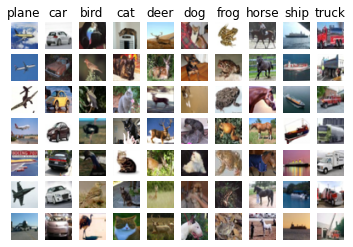

In [50]:
classifier.visualize()

In [45]:
classifier.crossValidation()

Accuracies of 5-fold cross-validation for different k's:

k = 3, accuracy = 0.200000
k = 3, accuracy = 0.300000
k = 3, accuracy = 0.000000
k = 3, accuracy = 0.200000
k = 3, accuracy = 0.000000
k = 3, average accuracy =0.140000

k = 5, accuracy = 0.200000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.000000
k = 5, accuracy = 0.100000
k = 5, accuracy = 0.000000
k = 5, average accuracy =0.080000

k = 7, accuracy = 0.000000
k = 7, accuracy = 0.200000
k = 7, accuracy = 0.000000
k = 7, accuracy = 0.100000
k = 7, accuracy = 0.000000
k = 7, average accuracy =0.060000

k = 11, accuracy = 0.100000
k = 11, accuracy = 0.000000
k = 11, accuracy = 0.000000
k = 11, accuracy = 0.100000
k = 11, accuracy = 0.100000
k = 11, average accuracy =0.060000



In [46]:
classifier.fit(7)

Got 1 / 10 correct => accuracy: 0.100000
